*   ID : M299X0762
*   Nama : Alfin Muhammad Ilmi
*   Kelas : M06

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
data = pd.read_csv('daily-min-temperatures.csv')
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
data.isnull().sum()

Date    0
Temp    0
dtype: int64

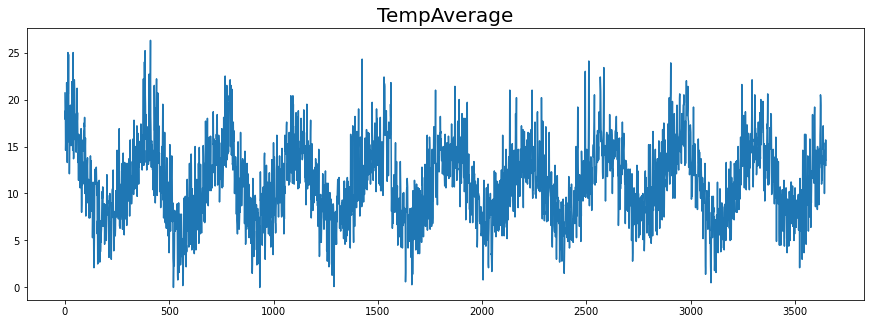

In [ ]:
dates = data.index.values.tolist() # Urutan Hari
temp  = data['Temp'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('TempAverage',
          fontsize=20);

In [ ]:
# Normalisasi Data Skala 0 s/d 1
from sklearn.preprocessing import MinMaxScaler

temp_reshape = temp.reshape(-1,1)
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(temp_reshape)
temp_normalisasi = min_max_scaler.transform(temp_reshape)
temp_normalisasi = temp_normalisasi.flatten()

In [ ]:
threshold_mae = (np.max(temp_normalisasi) - np.min(temp_normalisasi)) * 10/100

In [ ]:
threshold_mae

0.1

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split
dates_latih, dates_val, temp_latih, temp_val = train_test_split(dates, temp_normalisasi, 
                                                                test_size=0.2, shuffle=False)

In [ ]:
train_set = windowed_dataset(temp_latih, window_size=250, batch_size=128, shuffle_buffer=1000)
val_set = windowed_dataset(temp_val, window_size=250, batch_size=128, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(1)
])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
            print("!!! MAE DI BAWAH 10% !!!")
            self.model.stop_training = True

    def on_train_end(self, epoch, logs={}):
        print('Done, model berhenti')

callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=1e-4,
     momentum=0.9
    )
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=300, batch_size=64, validation_data=val_set, callbacks = callbacks)

Epoch 1/300
21/21 [==============================] - 6s 90ms/step - loss: 0.0300 - mae: 0.1952 - val_loss: 0.0091 - val_mae: 0.1075
Epoch 2/300
21/21 [==============================] - 1s 52ms/step - loss: 0.0106 - mae: 0.1143 - val_loss: 0.0052 - val_mae: 0.0795
Epoch 3/300
21/21 [==============================] - 1s 53ms/step - loss: 0.0093 - mae: 0.1066 - val_loss: 0.0051 - val_mae: 0.0781
Epoch 4/300
21/21 [==============================] - 1s 55ms/step - loss: 0.0080 - mae: 0.0996 - val_loss: 0.0049 - val_mae: 0.0763
Done, model berhenti
